# Seminar: Starter Notebook
This notebook helps you quickly use your DataLoading (and optionally DataGraphing) classes in Jupyter.

👉 Flow: Install → Paths → config.py → (optional) Credentials → Loader demos

## 0. inital settings

In [57]:
%pip install -q pandas numpy plotly kaleido yfinance fredapi ecbdata requests

Note: you may need to restart the kernel to use updated packages.


In [58]:
# Notebook is located at <PROJECT_ROOT>/notebooks/
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().resolve().parent        # one level up from /notebooks
SRC_ROOT = PROJECT_ROOT / "src"                   # parent of 'seminar_code'
sys.path.insert(0, str(SRC_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SRC_ROOT:", SRC_ROOT, "exists:", SRC_ROOT.exists())


PROJECT_ROOT: C:\Users\josef\Desktop\Seminar
SRC_ROOT: C:\Users\josef\Desktop\Seminar\src exists: True


In [59]:
# --- one-time import (per kernel) ---
from seminar_code.data_loading.data_loader import DataLoading
from seminar_code.data_graphing.data_grapher import DataGraphing  # optional

dl = DataLoading()
dg = DataGraphing()
print("Instances ready.")

Instances ready.


In [60]:
# --- hot reload after you edited the source files ---
import importlib

import seminar_code.data_loading.data_loader as dl_mod
import seminar_code.data_graphing.data_grapher as dg_mod  # optional

importlib.reload(dl_mod)
importlib.reload(dg_mod)  # optional

from seminar_code.data_loading.data_loader import DataLoading
from seminar_code.data_graphing.data_grapher import DataGraphing  # optional

dl = DataLoading()
dg = DataGraphing()
print("Modules reloaded and instances created.")


Modules reloaded and instances created.


In [61]:
import io, requests
import pandas as pd
import json
import statsmodels.api as sm
import matplotlib.pyplot as plt

from fredapi import Fred
from pathlib import Path
from seminar_code.data_loading.data_loader import DataLoading

## 2. load data

In [62]:
# Set dates
START_DATE = pd.Timestamp("2001-01-01")
END_DATE = pd.Timestamp("2025-01-01")

### 2.1. FRED

In [63]:
# --- FRED only: API key -> (ensure) loader -> fetch series ---
FRED_KEY = "4d07b674a78d08a1f75abfdd9a936bc8 "

# write/update secrets/credentials.json next to your project (one level above /notebooks)
PROJECT_ROOT = Path.cwd().resolve().parent   # assumes this notebook is in /notebooks
SECRETS_DIR  = PROJECT_ROOT / "secrets"
SECRETS_DIR.mkdir(parents=True, exist_ok=True)
CRED_FILE = SECRETS_DIR / "credentials.json"
CRED_FILE.write_text(json.dumps({"FRED_API": FRED_KEY, "US_Bureau_of_Labor_Statistics": ""}, indent=2),
                     encoding="utf-8")

92

In [64]:
# Quck and dirty way to set the API key in the DataLoading instance
from fredapi import Fred
dl = DataLoading()
dl.fred = Fred(api_key=FRED_KEY)

In [80]:
# fetch FRED series
fred_map = {"WTI": "DCOILWTICO", "Brent": "DCOILBRENTEU", "FedFundsRate": "DFF"}
series_dict, meta_dict, lowest = dl.get_fred_data(
    series_dict_mapping=fred_map,
    start_date=START_DATE,
    end_date=END_DATE
)

fred_df = pd.DataFrame(series_dict).astype(float)
fred_df.fillna(method="ffill", inplace=True)

2025-10-07 17:47:33,769 - INFO - Fetching data for variable WTI with series id: (DCOILWTICO) for start date: 2001-01-01 00:00:00 and end date: 2025-01-01 00:00:00
2025-10-07 17:47:34,765 - INFO - Inferred frequency for WTI is B
2025-10-07 17:47:34,766 - INFO - Fetching data for variable Brent with series id: (DCOILBRENTEU) for start date: 2001-01-01 00:00:00 and end date: 2025-01-01 00:00:00
2025-10-07 17:47:35,744 - INFO - Inferred frequency for Brent is B
2025-10-07 17:47:35,744 - INFO - Fetching data for variable FedFundsRate with series id: (DFF) for start date: 2001-01-01 00:00:00 and end date: 2025-01-01 00:00:00
2025-10-07 17:47:36,968 - INFO - Inferred frequency for FedFundsRate is D
2025-10-07 17:47:36,969 - INFO - Lowest (slowest) frequency: D


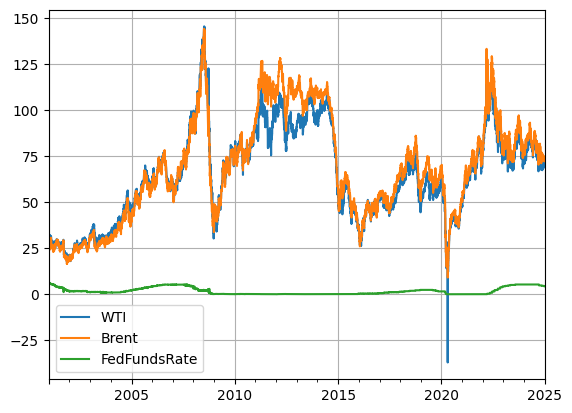

In [82]:
# Simple plot
fred_df['WTI'].plot(label="WTI")
fred_df['Brent'].plot(label="Brent")
fred_df['FedFundsRate'].plot(label="FedFundsRate")

plt.legend()
plt.grid()
plt.show()

### 2.2. BIS - Exchange rate basket

REF_AREA         US
TIME_PERIOD        
2025-09-26   104.07
2025-09-27      NaN
2025-09-28      NaN
2025-09-29   103.66
2025-09-30   103.58


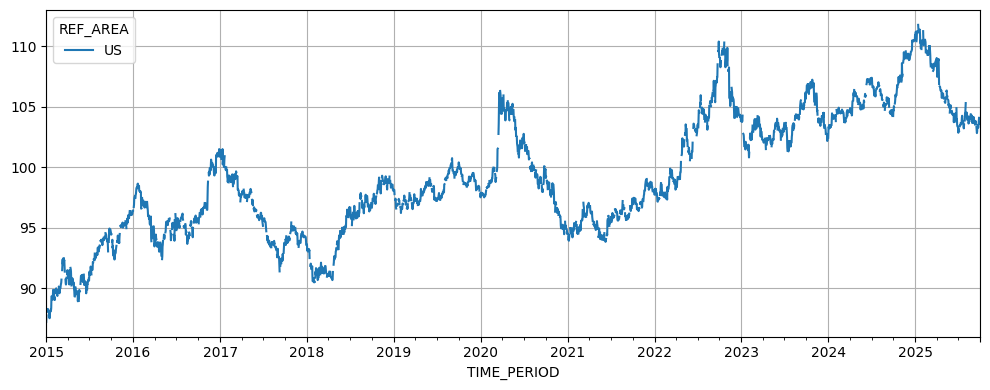

In [67]:
# call BIS API directly (no wrapper available yet)
# see https://www.bis.org/statistics/full_data_sets.htm?m=6%
BASE = "https://stats.bis.org/api/v1/data"
DATASET = "WS_EER"                 # <-- ohne _D !
KEY = "D.N.B.US"                   # D=daily, N=nominal, B=broad, US=US dollar

url = f"{BASE}/{DATASET}/{KEY}"
params = {"format": "csv", "startPeriod": "2015"}  # optional: start/end
r = requests.get(url, params=params, timeout=30)
r.raise_for_status()

# set up DataFrame
bis_df = pd.read_csv(io.StringIO(r.text))
wide = bis_df.pivot(index="TIME_PERIOD", columns="REF_AREA", values="OBS_VALUE")
wide.index = pd.to_datetime(wide.index)
wide.rename(columns={"DE": "Germany NEER (daily, broad)"}, inplace=True)

print(wide.tail())
wide.plot(figsize=(10,4)); plt.grid(True); plt.tight_layout(); plt.show()


In [68]:
bis_df

,FREQ,EER_TYPE,EER_BASKET,REF_AREA,UNIT_MEASURE,TIME_FORMAT,COLLECTION,TITLE_TS,TIME_PERIOD,OBS_VALUE,OBS_STATUS,OBS_CONF,OBS_PRE_BREAK
0,D,N,B,US,882,NaN,A,United States - Nominal - Broad (64 economies),2015-01-01,87.22,A,F,NaN
1,D,N,B,US,882,NaN,A,United States - Nominal - Broad (64 economies),2015-01-02,87.75,A,F,NaN
2,D,N,B,US,882,NaN,A,United States - Nominal - Broad (64 economies),2015-01-03,NaN,H,F,NaN
3,D,N,B,US,882,NaN,A,United States - Nominal - Broad (64 economies),2015-01-04,NaN,H,F,NaN
4,D,N,B,US,882,NaN,A,United States - Nominal - Broad (64 economies),2015-01-05,88.19,A,F,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3921,D,N,B,US,882,NaN,A,United States - Nominal - Broad (64 economies),2025-09-26,104.07,A,F,NaN
3922,D,N,B,US,882,NaN,A,United States - Nominal - Broad (64 economies),2025-09-27,NaN,H,F,NaN
3923,D,N,B,US,882,NaN,A,United States - Nominal - Broad (64 economies),2025-09-28,NaN,H,F,NaN
3924,D,N,B,US,882,NaN,A,United States - Nominal - Broad (64 economies),2025-09-29,103.66,A,F,NaN


### 2.3. yahoo Finance

In [69]:
# Yahoo Finance data
yf_df = dl.get_yahoo_data(
    ticker=["CL=F","NG=F"],                # WTI & NatGas futures
    start_date=START_DATE,
    end_date=END_DATE,
    auto_adjust=False,
    interval="1d"
)

[*********************100%***********************]  2 of 2 completed

FUNCTION: get_yahoo_data


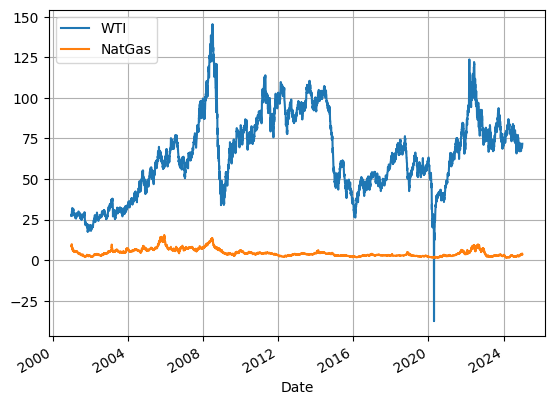

In [70]:
# Simple plot
yf_df['Close']['CL=F'].plot(label="WTI")
yf_df['Close']['NG=F'].plot(label="NatGas")

plt.legend()
plt.grid()
plt.show()

## 2. Markov switch application

Source: https://www.statsmodels.org/dev/examples/notebooks/generated/markov_regression.html?utm_source=chatgpt.com
- Didn't find this feature in the scikit learn bib, prob. best to condcut our econometric analysis with stats.
- ...

first dummy example

In [150]:
import numpy as np
import statsmodels.api as sm

In [ ]:
# Set time index
fred_df.index = pd.to_datetime(fred_df.index)

# Make data stationary
fred_stat_df = np.log(fred_df).pct_change().dropna()

# Define dummy data
wti_data = fred_stat_df['WTI'].loc['2020':]

In [ ]:
# Standardize (helps optimization - otherwise no convergence)
def standardize(series):
    return (series - series.mean()) / series.std()

wti_data = standardize(wti_data)

In [ ]:
# Augmented Dickey-Fuller test
adf_wti = sm.tsa.stattools.adfuller(wti_data)

print("ADF Statistic (WTI):", adf_wti[0], "p-value:", adf_wti[1], "critical_values:", adf_wti[4])

# The data is stationary if the ADF statistic is less than the critical value and the p-value is less than 0.05. 
# So we are good to go for Markov Switching/econmetric modeling..

ADF Statistic (WTI): -8.257339786601388 p-value: 5.19431037294698e-13 critical_values: {'1%': -3.4339840952648695, '5%': -2.8631452508003057, '10%': -2.567624583142913}


- Data is stationary if the ADF statistic is less than the critical value and the p-value is less than 0.05. 
- So we are good to go for Markov Switching/econmetric modeling..

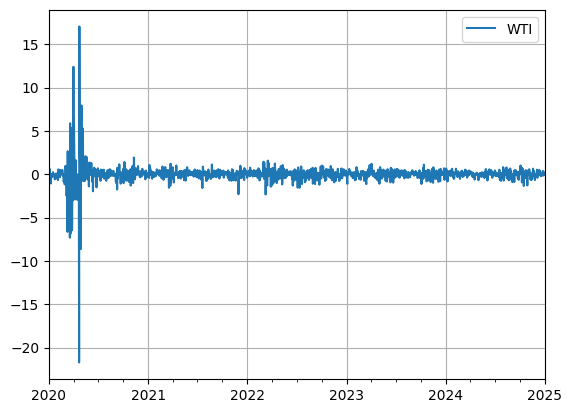

In [200]:
# Visual stationarity check
wti_data.plot(label="WTI")

plt.legend()
plt.grid()
plt.show()

---> Negative values periode might be problematic for log-returns and the model estimation. Will be filtered out in a first step.

In [196]:
# MS model test
mod = sm.tsa.MarkovRegression(
    wti_data,
    k_regimes=2, trend='n', switching_variance=True, freq='D'
    )

wti_res = mod.fit()
print(wti_res.summary())

                        Markov Switching Model Results                        
Dep. Variable:                    WTI   No. Observations:                 1828
Model:               MarkovRegression   Log Likelihood               -1071.241
Date:                 Di, 07 Okt 2025   AIC                           2150.482
Time:                        18:53:54   BIC                           2172.526
Sample:                    01-01-2020   HQIC                          2158.613
                         - 01-01-2025                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1187      0.006     20.394      0.000       0.107       0.130
                             Regime 1 parameters    

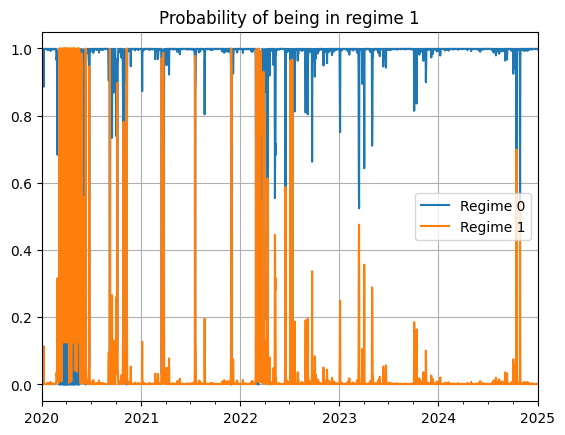

In [198]:
# See probability of being in regime 0 or 1
probs = wti_res.smoothed_marginal_probabilities
probs[0].plot(title="Probability of being in regime 0", label="Regime 0")
probs[1].plot(title="Probability of being in regime 1", label="Regime 1")

plt.legend()
plt.grid()
plt.show()

## 3. First Regression model -- FX vs GAS and Oil

In [ ]:
# Load data
